# A number recognition ML using Neural Network and MNIST dataset

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras import initializers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import applications
from tensorflow.keras import backend as K



2023-09-01 09:21:02.658470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the dataset

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.


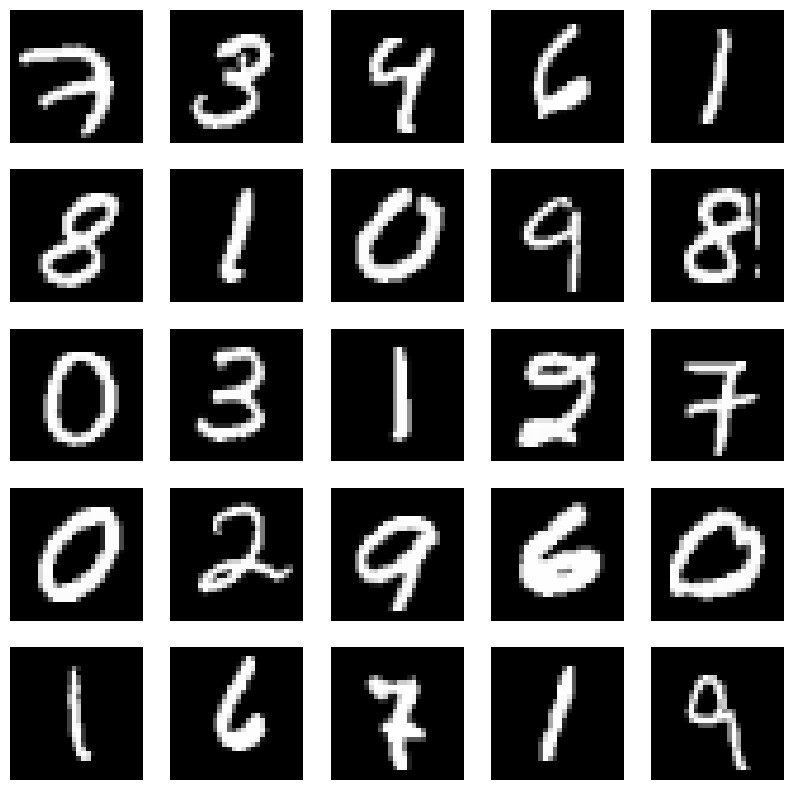

In [5]:
## plot some images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.show()


In [6]:
## explore the y_train range
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Build the Model using Dynamic Artificial Neural Network

in the context of the MNIST dataset, the input layer will have 784 neurons (28x28), the output layer will have 10 neurons (0-9), and the number of hidden layers and neurons is up to you. so I am going to use 300 neurons in the first hidden layer and 100 neurons in the second hidden layer. and also make sure to use the ReLU activation function for the hidden layers and the softmax activation function for the output layer. lastely, using callbacks to draw the learning curve dynamically.

In [7]:
K = tf.keras.backend
class ExponentialDecay(callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)


In [8]:
## set everyhting for the model backends 
K.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
## build the model
model = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [10]:
## build the optimizer and the loss function and the metrics of accuracy
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

## set the callbacks
lr_scheduler = ExponentialDecay(factor=1.005)

## Train the Model

In [11]:
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

1719/1719 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.6127 - val_loss: nan - val_accuracy: 0.0958


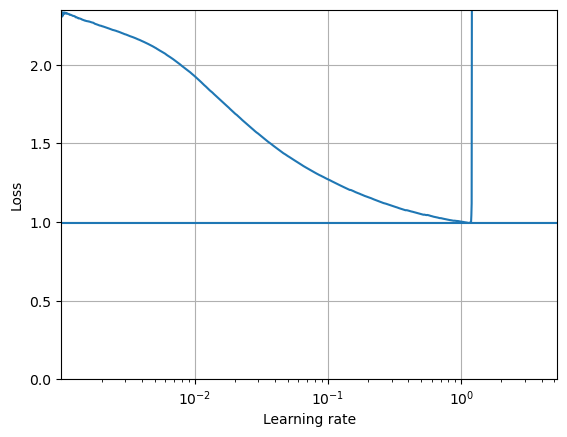

In [12]:
## plot the learning rate
plt.plot(lr_scheduler.rates, lr_scheduler.losses)
plt.gca().set_xscale('log')
plt.hlines(min(lr_scheduler.losses), min(lr_scheduler.rates), max(lr_scheduler.rates))
plt.axis([min(lr_scheduler.rates), max(lr_scheduler.rates), 0, lr_scheduler.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [13]:
## best learning rate
lr_scheduler.rates[np.argmin(lr_scheduler.losses)]


1.296067

In [14]:
## reset the model
K.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
mode = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, activation="relu"),
    layers.Dense(100, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [16]:
import os 
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])

## create a log directory
run = 1
run_logdir  = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run))
run_logdir
## set the callbacks
early_stopping_cb = callbacks.EarlyStopping(patience=20)
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = callbacks.TensorBoard(run_logdir)

In [17]:
## fit the model
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, lr_scheduler, checkpoint_cb, tensorboard_cb])


Epoch 1/100
1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.0990 - val_loss: nan - val_accuracy: 0.0958 - lr: 0.3000
Epoch 2/100
 148/1719 [=>............................] - ETA: 4s - loss: nan - accuracy: 0.0942

KeyboardInterrupt: 

In [ ]:
## Test the model
print(f'Test accuracy: {model.evaluate(X_test, y_test)[1]}')


In [ ]:
## run the tensorboard

%tensorboard --logdir=./my_mnist_logs --port=6006